In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

## Preprocessing

Mean price (or S in terms of Marco Avellaneda and Sasha Stoikov's article) is calculated using only the best bid\ask prices because otherwise it can be occurred that mean price is beyond best prices when a vast amount of orders concentrates on the one side. Also, weighted average is used in order to take into account possible imbalance between bids and asks.

Dynamics of mean price (Fig. 1) can show changing trends. Unfortunately, this information hardly can be implemented in any LO's strategy (A. Cartea, S. Jaimungal, J. Ricci, 2014) because of high time resolution. It's more convinient to model mean price as a standard Brownian motion.


*In the code below I tried to preserve labels from the articles of Marco Avellaneda and Sasha Stoikov, 2008 and  Alvaro Cartea, Ryan Donnelly, Sebastian Jaimungalc, 2015.

In [2]:
book = pd.read_csv('book.csv', nrows = 10**5)

# dropping useless columns to reduce RAM memory
book.drop(['exchange', 'symbol', 'timestamp'], axis = 1, inplace = True) 
book.sort_values(by = 'local_timestamp', inplace = True)

In [3]:
book.head()

,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,bids[1].price,bids[1].amount,asks[2].price,...,bids[22].price,bids[22].amount,asks[23].price,asks[23].amount,bids[23].price,bids[23].amount,asks[24].price,asks[24].amount,bids[24].price,bids[24].amount
0,1679443200485131264,28091.2,16.183,28091.1,0.001,28091.3,7.874,28091.0,0.003,28091.4,...,28087.8,0.006,28093.6,0.052,28087.7,0.036,28093.7,0.001,28087.6,0.002
1,1679443202065465600,28090.9,6.995,28090.8,0.002,28091.0,0.735,28090.7,0.002,28091.2,...,28087.6,0.002,28093.4,0.674,28087.5,0.099,28093.5,0.401,28087.4,0.001
2,1679443202691394048,28090.9,7.005,28090.8,0.002,28091.0,0.735,28090.7,0.002,28091.2,...,28087.6,0.002,28093.4,0.674,28087.5,0.099,28093.5,0.401,28087.4,0.001
3,1679443202812150528,28090.9,6.885,28090.8,0.002,28091.0,0.735,28090.7,0.002,28091.2,...,28087.6,0.002,28093.4,0.674,28087.5,0.099,28093.5,0.401,28087.4,0.001
4,1679443203188767744,28090.9,6.885,28090.8,0.002,28091.0,0.735,28090.7,0.002,28091.2,...,28087.6,0.002,28093.4,0.674,28087.5,0.099,28093.5,0.401,28087.4,0.001


In [4]:
# calucalting wieghted mean price, weights are volumes of best bid/ask 
book['mean_price'] = (book['asks[0].price'] * book['asks[0].amount'] \
                      + book['bids[0].price'] * book['bids[0].amount']) \
                    /(book['asks[0].amount'] + book['bids[0].amount'])

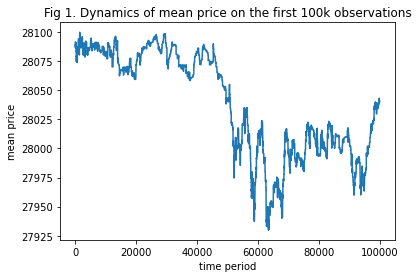

In [50]:
plt.plot(book['mean_price'])
plt.title('Fig 1. Dynamics of mean price on the first 100k observations')
plt.xlabel('time period')
plt.ylabel('mean price')
plt.show()

## Three basic strategies

Fundamental idea behind all these LO algorithms is putting bid and ask limit orders to the book by prices $p_b$ and $p_a$. Profit is made by the difference between prices at distinct time periods. The procedure can be described as follows:
1. At time $t$ agent calculates his bid/ask prices ($p_b$, $p_a$) depending on observed mean price and/or all price levels in the book.
2. At time $t+dt$ market prices change. If $p_b$ is greater than best bid price at period $t+dt$, limit order is considered executed and agent's inventory increases by $1$, profit (wealth) decreases by $p_b$. Simularily, if $p_a$ is less than best ask price, agent's inventory decreases by $1$, profit (wealth) increases by $p_a$.

In this section I try three approaches:
1. **Naive strategy** - $p_a$ and $p_b$ are equal to best bid/ask prices at time $t$. Agent wants to make profit only on difference between prices. 
2. **Inventory strategy** (M. Avellaneda and S. Stoikov, 2006) - according to given parameters agent calculates his total spread ($p_a - p_b$) and centers it around reservation price (price level at which agent is indifferent to whether to make deal or not). 
3. **Symmetric strategy** (M. Avellaneda and S. Stoikov, 2006) - very simular to inventory but centers optimal spread around mean price.

As the last two strategies have parameters to optimize, I devided data into 2 equal parts: train data (first 100'000 rows) and test data (following 100'000 rows). Optimizing algorithms is a simple grid search of 10 gammas and 10 sigmas. If we look closer to a contribution of these main parameters we will see that *with their increase the variation of profit in inventory strategy is reduced* (Fig. 2 and fig. 3). However, we can not state that to the symmetric strategy (Fig. 4 and fig. 5).

The results are clear (see Table 1. from the last section): *none of the three strategies give positive profit on test data*. Hence, they need to be improved.

Simulations have showed (M. Avellaneda and S. Stoikov, 2006) that symmetric strategy gives higher profits but with greater variation. Results on the presented data confirm that claim.

In [27]:
def LO_naive_strategy(book):
    '''
    book: pd.DataFrame object
    
    returns a list of profits (wealth state) for each period. The last element is a total profit 
    '''
    q = 0
    profit = 0
    profits = []

    for i in range(book.shape[0]-1):
        p_a = book['asks[0].price'].loc[i]
        p_b = book['bids[0].price'].loc[i]
        
        # if best ask price is greater than p_a then agent's sell order was executed
        if book['asks[0].price'].loc[i+1] > p_a:
            q -= 1
            profit += p_a
        
        # if best ask price is less than p_b then agent's buy order was executed
        if book['bids[0].price'].loc[i+1] < p_b:
            q += 1
            profit -= p_b


        profits.append(profit)

    profit += q*book['mean_price'].loc[book.shape[0]-1]
    profits.append(profit)
    return profits

In [42]:
LO_naive_strategy(book)[-1]

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:06<00:00, 16493.02it/s]


-3613.7683126702905

In [55]:
def LO_inventory_strategy(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    q = 0
    t = 0
    dt = T/book.shape[0] 
    profit = 0
    profits = []

    for i in range(book.shape[0]-1):
        
        # formulas directly from (M. Avellaneda and S. Stoikov, 2006) 
        res_price = book['mean_price'].loc[i] - q*gamma*(T-t)*sigma**2
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread / 2, total_spread / 2
        p_a = res_price + d_a # centering around reservation price
        p_b = res_price - d_b

        if book['asks[0].price'].loc[i+1] > p_a:
            q -= 1
            profit += p_a 
        if book['bids[0].price'].loc[i+1] < p_b:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[book.shape[0]-1]
    profits.append(profit)
    return profits

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:10<00:00, 9157.45it/s]


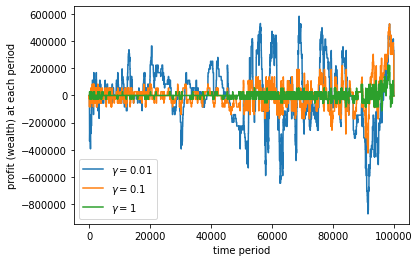

In [25]:
profits_1 = LO_inventory_strategy(book, gamma = 0.01)
profits_2 = LO_inventory_strategy(book, gamma = 0.1)
profits_3 = LO_inventory_strategy(book, gamma = 1)

fig, ax = plt.subplots()
ax.plot(profits_1, label = '$\gamma = 0.01$')
ax.plot(profits_2, label = '$\gamma = 0.1$')
ax.plot(profits_3, label = '$\gamma = 1$')
ax.legend()
ax.set_xlabel('time period')
ax.set_ylabel('profit (wealth) at each period')
ax.title('Fig 2. Profit curves of at different levels of gamma (inventory strategy)')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:10<00:00, 9162.08it/s]


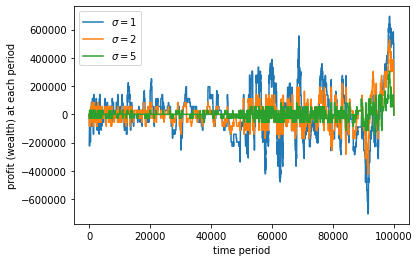

In [24]:
profits_1 = LO_inventory_strategy(book, sigma = 1)
profits_2 = LO_inventory_strategy(book, sigma = 2)
profits_3 = LO_inventory_strategy(book, sigma = 5)

fig, ax = plt.subplots()
ax.plot(profits_1, label = '$\sigma = 1$')
ax.plot(profits_2, label = '$\sigma = 2$')
ax.plot(profits_3, label = '$\sigma = 5$')
ax.legend()
ax.set_xlabel('time period')
ax.set_ylabel('profit (wealth) at each period')
ax.title('Fig 3. Profit curves at different levels of sigma (inventory strategy)')
plt.show()

In [9]:
# realisation of grid search to find best parameters for the presented data
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_inventory_strategy(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_inventory.npy', profits)

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:10<00:00, 9225.41it/s]


In [23]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 30
Optimal sigma is 9
Maximal profit is -4.219933489399409


In [56]:
def LO_sym_strategy(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread / 2, total_spread / 2
        p_a = book['mean_price'].loc[i] + d_a # centering around mean price
        p_b = book['mean_price'].loc[i] - d_b

        if book['asks[0].price'].loc[i+1] > p_a:
            q -= 1
            profit += p_a 
        if book['bids[0].price'].loc[i+1] < p_b:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:13<00:00, 7223.34it/s]


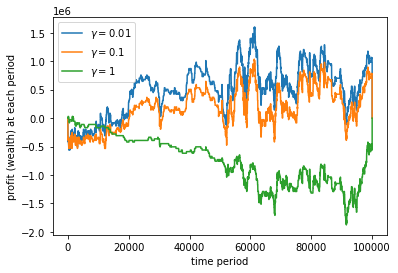

In [34]:
profits_1 = LO_sym_strategy(book, gamma = 0.01)
profits_2 = LO_sym_strategy(book, gamma = 0.1)
profits_3 = LO_sym_strategy(book, gamma = 1)

fig, ax = plt.subplots()
ax.plot(profits_1, label = '$\gamma = 0.01$')
ax.plot(profits_2, label = '$\gamma = 0.1$')
ax.plot(profits_3, label = '$\gamma = 1$')
ax.legend()
ax.set_xlabel('time period')
ax.set_ylabel('profit (wealth) at each period')
ax.title('Fig 4. Profit curves at different levels of gamma (symmetric strategy)')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:13<00:00, 7266.52it/s]


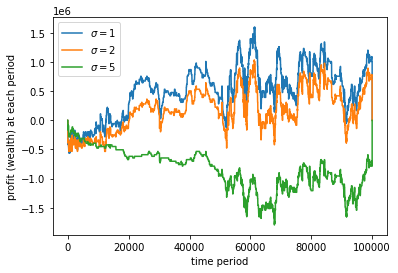

In [35]:
profits_1 = LO_sym_strategy(book, sigma = 1)
profits_2 = LO_sym_strategy(book, sigma = 2)
profits_3 = LO_sym_strategy(book, sigma = 5)

fig, ax = plt.subplots()
ax.plot(profits_1, label = '$\sigma = 1$')
ax.plot(profits_2, label = '$\sigma = 2$')
ax.plot(profits_3, label = '$\sigma = 5$')
ax.legend()
ax.set_xlabel('time period')
ax.set_ylabel('profit (wealth) at each period')
ax.title('Fig 5. Profit curves at different levels of sigma (symmetric strategy)')
plt.show()

In [36]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_sym_strategy(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_sym.npy', profits)

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:13<00:00, 7152.02it/s]


In [37]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 1
Optimal sigma is 4
Maximal profit is 370.11541902978206


In [57]:
# importing data (next 100k rows) to test all strategies
col_names = pd.read_csv('book.csv', nrows = 1).columns
book_test = pd.read_csv('book.csv', nrows = 2*(10**5), skiprows = 10**5, header = 0, names = col_names)
book_test['mean_price'] = (book_test['asks[0].price'] * book_test['asks[0].amount'] \
                      + book_test['bids[0].price'] * book_test['bids[0].amount']) \
                    /(book_test['asks[0].amount'] + book_test['bids[0].amount'])


profit_inventory = LO_inventory_strategy(book_test, gamma = 30, sigma = 9)
profit_sym = LO_sym_strategy(book_test, gamma = 1, sigma = 4)
profit_naive = LO_naive_strategy(book_test)
print(f'Profits for inventory, symmetric and naive strategies on test data are')
print(f'{profit_inventory[-1]}, \n{profit_sym[-1]}, \n{profit_naive[-1]} respectively')

Profits for inventory, symmetric and naive strategies on test data are
-44.01362439293007, 
192.5803389637731, 
-19070.59548631776 respectively


## Improvement of the strategies

All three improvements are based on idea to use information about amount of best bid/ask orders*. Volume index proposed in (A. Cartea, S. Jaimungal, J. Ricci, 2014) greatly fits our goal. 
$$
\rho = \frac{V_b-V_a}{V_a+V_b}, \
\rho \in [-1,1]
$$ 
where $V_b, V_a$ are amount of best bid/ask offers. 

To use this index as a propotion I scaled it:
$$
\rho^* = \frac{1}{2}\rho + \frac{1}{2}
$$

**Description of enhanced algorithms:**
- (0) Now $d_a$ and $d_b$ are not equal and calculated as $d_b = \text{total_spread} \cdot \rho, d_a = \text{total_spread} \cdot (1-\rho)$. Intuition behind this is simple: when buying pressure is strong agent should buy can afford it with less price. Otherwise, he should sell with higher price.
- (1) Previous improvement + limit orders are placed only if volume index in defined limits (A. Cartea, S. Jaimungal, J. Ricci, 2014). $\rho > \frac{4}{6}$ for buying order and $rho < \frac{2}{6}$ for selling one.
- (2) The same rule about placing orders but now $d_a = d_b = \frac{\text{total_spread}}{2}$

*Previous algorithms have used this information in mean price calculation but it's not a direct usage.

In [7]:
book['volume_index'] = (book['bids[0].amount'] - book['asks[0].amount']) \
                    /(book['bids[0].amount'] + book['asks[0].amount'])*1/2 + 1/2

In [30]:
def LO_sym_strategy_enhanced(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        
        # taking d_a and d_b propotional to volume index
        d_a, d_b = total_spread * (1-book['volume_index'].loc[i]), total_spread * book['volume_index'].loc[i] 
        p_a = book['mean_price'].loc[i] + d_a
        p_b = book['mean_price'].loc[i] - d_b

        if book['asks[0].price'].loc[i+1] > p_a:
            q -= 1
            profit += p_a 
        if book['bids[0].price'].loc[i+1] < p_b:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

In [23]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_sym_strategy_enhanced(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_sym_enhanced.npy', profits)

100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:11<00:00, 8431.39it/s]


In [25]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 45
Optimal sigma is 0.1
Maximal profit is 15139.795325011015


In [31]:
def LO_inventory_strategy_enhanced(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        res_price = book['mean_price'].loc[i] - q*gamma*(T-t)*sigma**2
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread * (1-book['volume_index'].loc[i]), total_spread * book['volume_index'].loc[i] 
        p_a = res_price + d_a
        p_b = res_price - d_b

        if book['asks[0].price'].loc[i+1] > p_a:
            q -= 1
            profit += p_a 
        if book['bids[0].price'].loc[i+1] < p_b:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

In [45]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_inventory_strategy_enhanced(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_inventory_enhanced.npy', profits)

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:09<00:00, 10450.27it/s]


In [46]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 0.1
Optimal sigma is 9
Maximal profit is -4886.697957107652


In [32]:
def LO_sym_strategy_enhanced_1(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread * (1-book['volume_index'].loc[i]), total_spread * book['volume_index'].loc[i] 
        p_a = book['mean_price'].loc[i] + d_a
        p_b = book['mean_price'].loc[i] - d_b
        
        # agent places his sell order if and only if volume index depicts sell-heavy market conjuncture
        if book['asks[0].price'].loc[i+1] > p_a and book['volume_index'].loc[i] < 1/6:
            q -= 1
            profit += p_a 
            
        # agent places his sell order if and only if volume index depicts buy-heavy market conjuncture
        if book['bids[0].price'].loc[i+1] < p_b and book['volume_index'].loc[i] > 2/3:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

In [20]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_sym_strategy_enhanced_1(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_sym_enhanced_1.npy', profits)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:03<00:00, 30.35s/it]


In [21]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 0.1
Optimal sigma is 0.1
Maximal profit is 824.3544835376088


In [33]:
def LO_sym_strategy_enhanced_2(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread / 2, total_spread / 2 
        p_a = book['mean_price'].loc[i] + d_a
        p_b = book['mean_price'].loc[i] - d_b
        
        # agent places his sell order if and only if volume index depicts sell-heavy market conjuncture
        if book['asks[0].price'].loc[i+1] > p_a and book['volume_index'].loc[i] < 1/6:
            q -= 1
            profit += p_a 
            
        # agent places his sell order if and only if volume index depicts buy-heavy market conjuncture
        if book['bids[0].price'].loc[i+1] < p_b and book['volume_index'].loc[i] > 2/3:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

In [22]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_sym_strategy_enhanced_2(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_sym_enhanced_2.npy', profits)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [26:20<00:00, 158.00s/it]


In [23]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 30
Optimal sigma is 0.1
Maximal profit is 760.0817641085014


In [39]:
def LO_inventory_strategy_enhanced_1(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        res_price = book['mean_price'].loc[i] - q*gamma*(T-t)*sigma**2
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread * (1-book['volume_index'].loc[i]), total_spread * book['volume_index'].loc[i] 
        p_a = res_price + d_a
        p_b = res_price - d_b

        # agent places his sell order if and only if volume index depicts sell-heavy market conjuncture
        if book['asks[0].price'].loc[i+1] > p_a and book['volume_index'].loc[i] < 1/6:
            q -= 1
            profit += p_a 
            
        # agent places his sell order if and only if volume index depicts buy-heavy market conjuncture
        if book['bids[0].price'].loc[i+1] < p_b and book['volume_index'].loc[i] > 2/3:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

In [40]:
def LO_inventory_strategy_enhanced_2(book, gamma = 0.1, k = 1.5, T = 1, sigma = 2):
    '''
    book: pd.DataFrame object
    gamma: float
    k: float
    T: int/float
    sigma: int/float 
    '''
    
    q = 0
    t = 0
    dt = T/book.shape[0]
    profit = 0
    profits = []

    for i in range(10**5-1):
        res_price = book['mean_price'].loc[i] - q*gamma*(T-t)*sigma**2
        total_spread = gamma*(T-t)*sigma**2 + 2*np.log(1+gamma/k)/gamma
        d_a, d_b = total_spread / 2, total_spread / 2 
        p_a = res_price + d_a
        p_b = res_price - d_b

        # agent places his sell order if and only if volume index depicts sell-heavy market conjuncture
        if book['asks[0].price'].loc[i+1] > p_a and book['volume_index'].loc[i] < 1/6:
            q -= 1
            profit += p_a 
            
        # agent places his sell order if and only if volume index depicts buy-heavy market conjuncture
        if book['bids[0].price'].loc[i+1] < p_b and book['volume_index'].loc[i] > 2/3:
            q += 1
            profit -= p_b


        t += dt
        profits.append(profit)

    profit += q*book['mean_price'].loc[10**5-1]
    profits.append(profit)
    return profits

In [41]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_inventory_strategy_enhanced_1(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_inventory_enhanced_1.npy', profits)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [28:07<00:00, 168.70s/it]


In [42]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 0.1
Optimal sigma is 0.1
Maximal profit is 824.4200300073717


In [43]:
gammas = [0.1,1,10,15,20,25,30,35,40,45]
sigmas = [0.1,1,2,3,4,5,6,7,8,9]
profits = np.zeros((10,10))


for i in tqdm(range(len(gammas))):
    for j in range(len(sigmas)):
        profits[i][j] += LO_inventory_strategy_enhanced_2(book, gamma = gammas[i], sigma = sigmas[j])[-1]

np.save('profits_matrix_inventory_enhanced_2.npy', profits)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [17:25<00:00, 104.54s/it]


In [44]:
best_gamma, best_sigma = np.where(profits == profits.max())[0][0], np.where(profits == profits.max())[1][0]
best_gamma = gammas[best_gamma]
best_sigma = sigmas[best_sigma]

print(f'Optimal gamma is {best_gamma}')
print(f'Optimal sigma is {best_sigma}')
print(f'Maximal profit is {profits.max()}')

Optimal gamma is 0.1
Optimal sigma is 0.1
Maximal profit is 421.92004523344804


In [54]:
# testing all enhanced strategies on the same data (following 100k rows)
book_test['volume_index'] = (book_test['bids[0].amount'] - book_test['asks[0].amount']) \
                    /(book_test['bids[0].amount'] + book_test['asks[0].amount'])*1/2 + 1/2

profit_inventory_enhanced = LO_inventory_strategy_enhanced(book_test, gamma = 0.1, sigma = 9)[-1]
profit_sym_enhanced = LO_sym_strategy_enhanced(book_test, gamma = 45, sigma = 0.1)[-1]
profit_sym_enhanced_1 = LO_sym_strategy_enhanced_1(book_test, gamma = 0.1, sigma = 0.1)[-1]
profit_sym_enhanced_2 = LO_sym_strategy_enhanced_2(book_test, gamma = 30, sigma = 0.1)[-1]
profit_inventory_enhanced_1 = LO_inventory_strategy_enhanced_1(book_test, gamma = 0.1, sigma = 0.1)[-1]
profit_inventory_enhanced_2 = LO_inventory_strategy_enhanced_2(book_test, gamma = 0.1, sigma = 0.1)[-1]

print(f'Profits on test data for inventory and symmetric strategies are \n{profit_inventory_enhanced}, \n{profit_sym_enhanced} respectively.')
print(f'And for enhanced one: \n-symmetric (1) {profit_sym_enhanced_1}, \n-symmetric (2) {profit_sym_enhanced_2},  \n-inventory (1) {profit_inventory_enhanced_1}, \n-inventory (2) {profit_inventory_enhanced_2}.')

Profits on test data for inventory and symmetric strategies are 
-3525.927931930197, 
-20064.144567154348 respectively.
And for enhanced one: 
-symmetric (1) 799.0402231210028, 
-symmetric (2) 1548.781926105381,  
-inventory (1) 799.0887001259835, 
-inventory (2) 798.7488340765703.


## Results

|Strategy\Data                    | train data | test data |
|--------------------|------------|-----------|
| naive              | -3613.79   | -19070.59 |
| inventory          | -4.22      | -44.01     |
| symmetric          | **370.12**     | **192.58**   |
| inventory enhanced | -4886.69   | -3948.38  |
| symmetric enhanced | **15139.79**   | -32891.15 |
| symmetric enhanced (1) | **824.36**   | **799.04** |
| symmetric enhanced (2) | **760.08**   | **1548.78** |
| inventory enhanced (1) | **824.42**   | **799.09** |
| inventory enhanced (2)| **421.92**   | **798.75** |

**Positive profits on test data are observed in all non-zero enhanced strategies which proves their effiency compared to other trading algorithms**. 